# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Цель данного проекта - спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком.

Описание данных:

Признаки
-	RowNumber — индекс строки в данных
-   CustomerId — уникальный идентификатор клиента
-	Surname — фамилия
-	CreditScore — кредитный рейтинг
-	Geography — страна проживания
-	Gender — пол
-	Age — возраст
-	Tenure — сколько лет человек является клиентом банка
-	Balance — баланс на счёте
-	NumOfProducts — количество продуктов банка, используемых клиентом
-	HasCrCard — наличие кредитной карты
-	IsActiveMember — активность клиента
-	EstimatedSalary — предполагаемая зарплата

Целевой признак
-	Exited — факт ухода клиента

Для реализации поставленной цели будут проделаны следующие шаги: загружены и подготовлены данные; исследован баланс классов; обучены модели без учёта дисбаланса; улучшено качество моделей, учитывая дисбаланс классов; обучены разные модели с целью найти лучшую (с предельно большим значением F1-меры); измерено AUC-ROC, проведено финальное тестирование лучшей модели.


## Подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

**Открытие и изучение файла**

In [ ]:
df = pd.read_csv('/datasets/Churn.csv')

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Рассматриваемая таблица состоит из 14 столбцов и 10000 строк, в столбце Tenure есть пропуски, присутствует три столбца с типом данных object.

In [ ]:
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Слабая положительная корреляция присутсвует между Age - Exited и между  Balance-Exited. Слабая отрицательная корреляция присутсвует между Balance - NumOfProducts и между Exited - IsActiveMember. Корреляция между остальными признаками практически нулевая.

In [ ]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Видно, что в столбцах с количественными показателями (CreditScore, Age, Tenure, EstimatedSalary) среднее и медиана близки, значительное различие в данных показателях есть только в столбце Balance.

In [ ]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [ ]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [ ]:
df[df['Tenure'].isna()].pivot_table(index = 'Exited', values = 'Age', aggfunc = 'count')

,Age
Exited,
0,726
1,183


In [ ]:
table = df.pivot_table(index = 'Exited', columns = 'Tenure', values = 'Age', aggfunc = 'count')

In [ ]:
table

Tenure,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Exited,,,,,,,,,,,
0,292,739,765,730,701,740,704,765,759,688,354
1,90,213,185,198,184,187,177,160,174,194,92


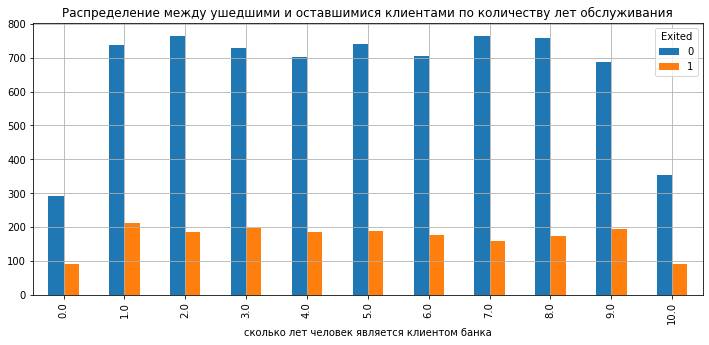

In [ ]:
table.T.plot.bar(figsize=(12,5), grid=True, xlabel='сколько лет человек является клиентом банка',
                 title='Распределение между ушедшими и оставшимися клиентами по количеству лет обслуживания');

В столбце Tenure присутствуют пропуски

**Подготовка данных**

In [ ]:
df = df.dropna()

Строки с пропусками были удалены, т.к. восстановить их не представляется возможным

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


In [ ]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

Столбцы 'RowNumber', 'CustomerId', 'Surname' для обучения модели не понадобятся, т.к. данные в указанных столбцах носят просто идентификационный характер(индекс строки, ID клиента, фамилия клиента), поэтому их удаляем.

In [ ]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Разбивка данных на выборки**

In [ ]:
target = df['Exited']
features = df.drop('Exited', axis=1)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                              test_size=0.4,
                                                                              random_state=12345,
                                                                              stratify=target)

In [ ]:
print(features_train.shape)
print(target_train.shape)

(5454, 10)
(5454,)


In [ ]:
print(features_test.shape)
print(target_test.shape)

(3637, 10)
(3637,)


In [ ]:
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test,
                                                                            test_size=0.5,
                                                                            random_state=12345,
                                                                            stratify=target_test)

In [ ]:
print(features_test.shape)
print(target_test.shape)

(1818, 10)
(1818,)


In [ ]:
print(features_valid.shape)
print(target_valid.shape)

(1819, 10)
(1819,)


**Преобразование категориальных признаков в численные**

In [ ]:
encoder_ohe = OneHotEncoder(drop='first', sparse=False)

In [ ]:
ohe_columns = ['Geography', 'Gender']

In [ ]:
encoder_ohe.fit(features_train[ohe_columns])

OneHotEncoder(drop='first', sparse=False)

In [ ]:
def func_ohe(semple):
    semple[encoder_ohe.get_feature_names()] = encoder_ohe.transform(semple[ohe_columns])
    semple = semple.drop(ohe_columns, axis=1)
    return semple

In [ ]:
features_train = func_ohe(features_train)

In [ ]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
9723,526,32,7.0,125540.05,1,0,0,86786.41,0.0,0.0,1.0
1224,500,47,8.0,128486.11,1,1,0,179227.12,0.0,1.0,0.0
8377,802,40,4.0,0.00,2,1,1,81908.09,0.0,1.0,1.0
8014,731,39,2.0,126816.18,1,1,1,74850.93,0.0,1.0,0.0
2491,612,26,4.0,0.00,2,1,1,179780.74,0.0,1.0,0.0


In [ ]:
features_valid = func_ohe(features_valid)

In [ ]:
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
4126,675,32,10.0,0.00,2,1,0,191545.65,0.0,1.0,1.0
5145,784,38,1.0,138515.02,1,1,1,171768.76,1.0,0.0,1.0
9253,644,49,10.0,0.00,2,1,1,145089.64,0.0,1.0,1.0
6757,717,36,2.0,102989.83,2,0,1,49185.57,0.0,1.0,1.0
9739,677,25,3.0,0.00,2,1,0,179608.96,0.0,0.0,0.0


In [ ]:
features_test = func_ohe(features_test)

In [ ]:
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
7493,610,37,10.0,140363.95,2,1,1,129563.86,0.0,1.0,0.0
5460,661,41,5.0,122552.48,2,0,1,120646.40,1.0,0.0,1.0
9126,753,51,4.0,79811.72,2,0,1,68260.27,0.0,1.0,1.0
9801,569,30,3.0,139528.23,1,1,1,33230.37,0.0,1.0,0.0
9101,597,38,6.0,115702.67,2,1,1,25059.05,0.0,1.0,1.0


In [ ]:
features_train.shape, features_valid.shape, features_test.shape

((5454, 11), (1819, 11), (1818, 11))

**Стандартизация данных**

In [ ]:
scaler = StandardScaler()

In [ ]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [ ]:
scaler.fit(features_train[numeric])

StandardScaler()

In [ ]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

In [ ]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
9723,-1.292898,-0.660843,0.686341,0.786636,-0.910943,0,0,-0.223548,0.0,0.0,1.0
1224,-1.563714,0.778434,1.034232,0.833795,-0.910943,1,0,1.383021,0.0,1.0,0.0
8377,1.581914,0.106771,-0.357331,-1.222967,0.789359,1,1,-0.308331,0.0,1.0,1.0
8014,0.842379,0.010820,-1.053112,0.807063,-0.910943,1,1,-0.430980,0.0,1.0,0.0
2491,-0.397123,-1.236554,-0.357331,-1.222967,0.789359,1,1,1.392642,0.0,1.0,0.0


С целью подготовки данных была проведена предобработка: в столбце Tenure присутствовали пропуски, восстановить данные на основе имеющихся не представляется возможным, заполнение пропусков другими значениями может привести к искажению, поэтому строки с пропусками были удалены; столбцы 'RowNumber', 'CustomerId', 'Surname' также были удалены, т.к. данные в них носят просто идентификационный характер(индекс строки, ID клиента, фамилия клиента) и для обучения модели не понадобятся. Предобработанные данные были разбиты на выборки (обучающую, валидационную и тестовую) в следующих пропорциях 60-20-20. Категориальные признаки преобразованы в численные с помощью OneHotEncoder. Также была проведена стандартизация данных. Т.о. данные для дальнейшего обучения моделей подготовлены.

## Исследование задачи

In [ ]:
df.groupby('Exited').size()/len(df)

Exited
0    0.796062
1    0.203938
dtype: float64

In [ ]:
def func_dt(x_train, y_train, weight):
    best_model_dt = None
    best_f1_dt = 0
    max_depth_dt = 0
    for i in range(1,30):
        model_dt = DecisionTreeClassifier(random_state=12345, criterion='gini', max_depth = i,
                                         class_weight=weight)
        model_dt.fit(x_train, y_train)
        predicted_valid = model_dt.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        if f1 > best_f1_dt:
            best_model_dt = model_dt
            best_f1_dt = f1
            max_depth_dt = i
    probabilities_valid = best_model_dt.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc_auc_dt = roc_auc_score(target_valid, probabilities_one_valid)
    return best_model_dt, best_f1_dt, roc_auc_dt

In [ ]:
model_dt, f1_dt, auc_dt = func_dt(features_train, target_train, None)

In [ ]:
print(model_dt,', F1:', f1_dt,', AUC-ROC:', auc_dt)

DecisionTreeClassifier(max_depth=7, random_state=12345) , F1: 0.557659208261618 , AUC-ROC: 0.8173603148128844


In [ ]:
def func_rf(x_train, y_train, weight):
    best_model_rf = None
    best_f1_rf = 0
    n_estimators = 0
    max_depth = 0
    for est in range(1, 30):
        for depth in range(1, 15):
            model_rf = RandomForestClassifier(random_state=12345, n_estimators=est,
                                              max_depth=depth, criterion='gini', class_weight=weight)
            model_rf.fit(x_train, y_train)
            predicted_valid = model_rf.predict(features_valid)
            f1_rf = f1_score(target_valid, predicted_valid)
            if f1_rf > best_f1_rf:
                best_model_rf = model_rf
                best_f1_rf = f1_rf
                n_estimators = est
                max_depth = depth
    probabilities_valid = best_model_rf.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_rf = roc_auc_score(target_valid, probabilities_one_valid)
    return best_model_rf, best_f1_rf, auc_rf

In [ ]:
%%time
model_rf, f1_rf, auc_rf = func_rf(features_train, target_train, None)

CPU times: user 28.5 s, sys: 79.9 ms, total: 28.6 s
Wall time: 28.6 s


In [ ]:
print(model_rf, "F1:", f1_rf,
      '\n' 'AUC-ROC:', auc_rf)

RandomForestClassifier(max_depth=10, n_estimators=16, random_state=12345) F1: 0.5831903945111492 
AUC-ROC: 0.841564161367664


In [ ]:
def func_lr(x_train, y_train, weight):
    model_lr = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000,
                                  class_weight=weight)
    model_lr.fit(x_train, y_train)
    predicted_valid = model_lr.predict(features_valid)
    probabilities_valid = model_lr.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    f1_lr = f1_score(target_valid, predicted_valid)
    auc_lr = roc_auc_score(target_valid, probabilities_one_valid)
    return model_lr, f1_lr, auc_lr

In [ ]:
model_lr, f1_lr, auc_lr = func_lr(features_train, target_train, None)

In [ ]:
print(model_lr,', F1:', f1_lr, '\n' 'AUC-ROC:', auc_lr)

LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear') , F1: 0.35203094777562866 
AUC-ROC: 0.7743592798320205


В данных присутствует дисбаланс классов. Проведено обучение моделей без учета дисбаланса при помощи трех алгоритмов обучения. Видно, что дисбаланс оказывает влияние на качество модели, качество моделей не высокое. Самое сильное влияние - на модель, обученную LogisticRegression. Лучшие результаты были получены у модели, обученной алгоритмом RandomForest, с параметром n_estimators = 16, max_depth = 10. Худшие у модели, обученной LogisticRegression.

## Борьба с дисбалансом

**Взвешевание классов**

In [ ]:
model_lr_w, f1_lr_w, auc_lr_w = func_lr(features_train, target_train, 'balanced')

In [ ]:
print(model_lr_w, '\n' 'F1:', f1_lr_w, '\n' 'AUC-ROC:', auc_lr_w)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12345,
                   solver='liblinear') 
F1: 0.5087040618955513 
AUC-ROC: 0.778158553111644


In [ ]:
model_dt_w, f1_dt_w, auc_dt_w = func_dt(features_train, target_train, 'balanced')

In [ ]:
print(model_dt_w, '\n' 'F1:', f1_dt_w, '\n' 'AUC-ROC:', auc_dt_w)

DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=12345) 
F1: 0.5675675675675674 
AUC-ROC: 0.805204874089738


In [ ]:
%%time
model_rf_w, f1_rf_w, auc_rf_w = func_rf(features_train, target_train, 'balanced')

CPU times: user 28.9 s, sys: 83.6 ms, total: 29 s
Wall time: 29.2 s


In [ ]:
print(model_rf_w, '\n' 'F1:', f1_rf_w, '\n' 'AUC-ROC:', auc_rf_w)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=23,
                       random_state=12345) 
F1: 0.6174863387978142 
AUC-ROC: 0.8446318744322499


**Увеличение выборки**

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [ ]:
features_upsampled.shape, target_upsampled.shape

((8790, 11), (8790,))

In [ ]:
target_upsampled.value_counts()

1    4448
0    4342
Name: Exited, dtype: int64

In [ ]:
model_lr_up, f1_lr_up, auc_lr_up = func_lr(features_upsampled, target_upsampled, None)

In [ ]:
print(model_lr_up, '\n' 'F1:', f1_lr_up, '\n' 'AUC-ROC:', auc_lr_up)

LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear') 
F1: 0.5042816365366317 
AUC-ROC: 0.7781846137808819


In [ ]:
model_dt_up, f1_dt_up, auc_dt_up = func_dt(features_upsampled, target_upsampled, None)

In [ ]:
print(model_dt_up, '\n' 'F1:', f1_dt_up, '\n' 'AUC-ROC:', auc_dt_up)

DecisionTreeClassifier(max_depth=8, random_state=12345) 
F1: 0.5711060948081264 
AUC-ROC: 0.8083321543982964


In [ ]:
%%time
model_rf_up, f1_rf_up, auc_rf_up = func_rf(features_upsampled, target_upsampled, None)

CPU times: user 38 s, sys: 164 ms, total: 38.2 s
Wall time: 38.2 s


In [ ]:
print(model_rf_up, '\n' 'F1:', f1_rf_up, '\n' 'AUC-ROC:', auc_rf_up)

RandomForestClassifier(max_depth=13, n_estimators=17, random_state=12345) 
F1: 0.6177285318559558 
AUC-ROC: 0.8305637667346727


**Уменьшение выборки**

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] +
                                   [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,
                                                       random_state=12345)
    return features_downsampled, target_downsampled

In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.26)

In [ ]:
features_downsampled.shape, target_downsampled.shape

((2241, 11), (2241,))

In [ ]:
target_downsampled.value_counts()

0    1129
1    1112
Name: Exited, dtype: int64

In [ ]:
model_lr_dow, f1_lr_dow, auc_lr_dow = func_lr(features_downsampled, target_downsampled, None)

In [ ]:
print(model_lr_dow, '\n' 'F1:', f1_lr_dow, '\n' 'AUC-ROC:', auc_lr_dow)

LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear') 
F1: 0.5081809432146294 
AUC-ROC: 0.7793740971839586


In [ ]:
model_dt_dow, f1_dt_dow, auc_dt_dow = func_dt(features_downsampled, target_downsampled, None)

In [ ]:
print(model_dt_dow, '\n' 'F1:', f1_dt_dow, '\n' 'AUC-ROC:', auc_dt_dow)

DecisionTreeClassifier(max_depth=8, random_state=12345) 
F1: 0.5631469979296065 
AUC-ROC: 0.7992490804306711


In [ ]:
%%time
model_rf_dow, f1_rf_dow, auc_rf_dow = func_rf(features_downsampled, target_downsampled, None)

CPU times: user 18.2 s, sys: 180 ms, total: 18.4 s
Wall time: 18.4 s


In [ ]:
print(model_rf_dow, '\n' 'F1:', f1_rf_dow, '\n' 'AUC-ROC:', auc_rf_dow)

RandomForestClassifier(max_depth=6, n_estimators=12, random_state=12345) 
F1: 0.5977011494252874 
AUC-ROC: 0.8517697055888966


Взвешивание классов и увеличение выборки дали похожие результаты в улучшении качества модели, в тоже время уменьшение выборки показало худшие результаты. Лучшие результаты у моделей, обученных алгоритмом RandomForest, худшие у моделей, обученных LogisticRegression.

In [ ]:
table = pd.DataFrame([['-', model_lr, f1_lr, auc_lr],
['-', model_dt, f1_dt, auc_dt],
['-', str(model_rf), f1_rf, auc_rf],
['взвешивание классов', model_lr_w, f1_lr_w, auc_lr_w],
['взвешивание классов', model_dt_w, f1_dt_w, auc_dt_w],
['взвешивание классов', str(model_rf_w), f1_rf_w, auc_rf_w],
['увеличение выборки', model_lr_up, f1_lr_up, auc_lr_up],
['увеличение выборки', model_dt_up, f1_dt_up, auc_dt_up],
['увеличение выборки', str(model_rf_up), f1_rf_up, auc_rf_up],
['уменьшение выборки', model_lr_dow, f1_lr_dow, auc_lr_dow],
['уменьшение выборки', model_dt_dow, f1_dt_dow, auc_dt_dow],
['уменьшение выборки', str(model_rf_dow), f1_rf_dow, auc_rf_dow]],
columns=['метод борьбы с дисбалансом', 'модель', 'F1', 'AUC-ROC'])
table = table.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
table.set_properties(**{'text-align': 'left'}).hide_index()

метод борьбы с дисбалансом,модель,F1,AUC-ROC
-,"LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear')",0.352031,0.774359
-,"DecisionTreeClassifier(max_depth=7, random_state=12345)",0.557659,0.817360
-,"RandomForestClassifier(max_depth=10, n_estimators=16, random_state=12345)",0.583190,0.841564
взвешивание классов,"LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12345, solver='liblinear')",0.508704,0.778159
взвешивание классов,"DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=12345)",0.567568,0.805205
взвешивание классов,"RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=23, random_state=12345)",0.617486,0.844632
увеличение выборки,"LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear')",0.504282,0.778185
увеличение выборки,"DecisionTreeClassifier(max_depth=8, random_state=12345)",0.571106,0.808332
увеличение выборки,"RandomForestClassifier(max_depth=13, n_estimators=17, random_state=12345)",0.617729,0.830564
уменьшение выборки,"LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear')",0.508181,0.779374


Лучшие результаты у моделей, обученных алгоритмом RandomForest - взвешивание классов при параметрах n_estimators = 23,  max_depth = 10 значение F1 = 0.6174863387978142, AUC-ROC = 0.8446318744322499,  увеличение выборки при параметрах n_estimators = 17,  max_depth = 13 значение F1 = 0.6177285318559558, AUC-ROC = 0.8305637667346727. Показатели очень близкие, ориентируясь на значение F1, для тестирования остановимся на модели сбалансированной увеличением выборки. Рассматривая другие алгоритмы можно отметить, что на модели, обученные LogisticRegression все три рассмотренных метода борьбы с дисбалансом дают практически идентичные результаты (показатели F1 и AUC-ROC при изменении метода практически не меняются).
Для моделей обученных DecisionTreeClassifier также результаты практически не отличаются, присутствует очень незначительное улучшение при увеличении выборки.

## Тестирование модели

In [ ]:
model_rf_up.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print("F1:", f1_score(target_test, predicted_test),
      ', AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))

F1: 0.6236559139784946 , AUC-ROC: 0.855005336815458


В нашем распоряжении были исторические данные о поведении клиентов и расторжении договоров с банком. Таблица с данными состояла из 14 столбцов и 10000 строк.
Была выполнена подготовка данных: в столбце Tenure присутствовали пропуски, восстановить которые не представлялось возможным, поэтому строки с пропусками были удалены; столбцы 'RowNumber', 'CustomerId', 'Surname' также были удалены, т.к. данные в них носят просто идентификационный характер(индекс строки, ID клиента, фамилия клиента) и для обучения модели не понадобятся. Предобработанные данные были разбиты на выборки (обучающую, валидационную и тестовую) в следующих пропорциях 60-20-20. Категориальные признаки преобразованы в численные с помощью OneHotEncoder. Также была проведена стандартизация данных.

В данных присутствовал дисбаланс классов. Было проведено обучение моделей при помощи трех алгоритмов - LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, что показало - дисбаланс оказывает влияние на качество моделей (оно не высокое). Лучшие результаты были получены у модели, обученной алгоритмом RandomForestClassifier(n_estimators = 16, max_depth = 10). Худшие у модели, обученной LogisticRegression.

Для улучшения качества моделей использовались три метода – взвешивание классов, увеличение выборки и уменьшение выборки. Первые два метода показали  похожие результаты в улучшении качества модели, в тоже время уменьшение выборки показало худшие результаты.
Лучшие результаты у моделей, обученных алгоритмом RandomForest
- взвешивание классов при параметрах n_estimators = 23, max_depth = 10, значение F1 = 0.6174863387978142, AUC-ROC = 0.8446318744322499,
- увеличение выборки при параметрах n_estimators = 17, max_depth = 13, значение F1 = 0.6177285318559558, AUC-ROC = 0.8305637667346727.

Показатели очень близкие, ориентируясь на значение F1, для тестирования была выбрана модель, сбалансированная увеличением выборки.

Рассматривая другие алгоритмы можно отметить, что на модели, обученные LogisticRegression все три рассмотренных метода борьбы с дисбалансом дают практически идентичные результаты (показатели F1 и AUC-ROC при изменении метода практически не меняются) и в тоже время данные методы лучше всего сказались именно на ней. Для моделей обученных DecisionTreeClassifier также результаты практически не отличаются, присутствует очень незначительное улучшение при увеличении выборки.

Тестирование лучшей модели показало хорошие результаты. Модель RandomForestClassifier(max_depth=13, n_estimators=17) можно рекомендовать использовать для прогнозирования, уйдёт клиент из банка в ближайшее время или нет.

